In [57]:
import torch
import librosa
import librosa.display
import torchaudio

import os
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


In [58]:
eng_data=pd.read_csv('C:/Users/Sania Serrao/projects/SpeechIntent/data/eng_data.csv')
eng_data.drop(columns=['filepath'], inplace=True)
eng_data.head()

,text_asr,text_translated,intent,language,full_audio_path
0,I would like to pay my electricity bill using ...,I would like to pay my electricity bill using ...,PAY_BILL,en-AU,MInDS-14\audio\en-AU~PAY_BILL/response_4.wav
1,hello I like to pay for Bill I would actually ...,hello I like to pay for Bill I would actually ...,PAY_BILL,en-AU,MInDS-14\audio\en-AU~PAY_BILL/response_17.wav
2,pay a bill,pay a bill,PAY_BILL,en-AU,MInDS-14\audio\en-AU~PAY_BILL/response_16.wav
3,my credit card payment is due,my credit card payment is due,PAY_BILL,en-AU,MInDS-14\audio\en-AU~PAY_BILL/response_7.wav
4,hi I would like to make a new payment for a bill,hi I would like to make a new payment for a bill,PAY_BILL,en-AU,MInDS-14\audio\en-AU~PAY_BILL/response_14.wav


In [59]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [60]:
eng_data['audio_exists'] = eng_data['full_audio_path'].apply(os.path.exists)
print(f"Audio files exist: {eng_data['audio_exists'].sum()} / {len(eng_data)}")

# Keep only rows where audio exists
eng_data = eng_data[eng_data['audio_exists']]
eng_data = eng_data.drop(columns=['audio_exists'])

Audio files exist: 1809 / 1809


In [61]:
from sklearn.preprocessing import LabelEncoder


#splitting data into 7:1.5:1.5 ratio for train, validation and test
train_data, temp_data = train_test_split(eng_data, test_size=0.3, random_state=42, stratify=eng_data['intent'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['intent'])


print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")


# Before creating datasets
label_encoder = LabelEncoder()
all_intents = pd.concat([train_data, val_data, test_data])['intent']
label_encoder.fit(all_intents)

train_data['intent'] = label_encoder.transform(train_data['intent'])
val_data['intent'] = label_encoder.transform(val_data['intent'])
test_data['intent'] = label_encoder.transform(test_data['intent'])

# Save class names for later interpretation
class_names = label_encoder.classes_


output_dir = "data"
train_data.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
val_data.to_csv(os.path.join(output_dir, 'val.csv'), index=False)
test_data.to_csv(os.path.join(output_dir, 'test.csv'), index=False)

Train: 1266, Validation: 271, Test: 272


In [62]:
print(f'Classes: {class_names}')
print(f'Number of classes: {len(class_names)}')

Classes: ['ABROAD' 'ADDRESS' 'APP_ERROR' 'ATM_LIMIT' 'BALANCE' 'BUSINESS_LOAN'
 'CARD_ISSUES' 'CASH_DEPOSIT' 'DIRECT_DEBIT' 'FREEZE' 'HIGH_VALUE_PAYMENT'
 'JOINT_ACCOUNT' 'LATEST_TRANSACTIONS' 'PAY_BILL']
Number of classes: 14


In [63]:
#processing the text and audio data for feature extractors

def preprocess_audio(file_path, target_sr=16000):
    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
        
    if sample_rate != target_sr: 
        resampler = torchaudio.transforms.Resample(sample_rate, target_sr)
        waveform = resampler(waveform)

    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=target_sr,
        n_fft=1024,
        hop_length=512,
        n_mels=80
    )(waveform)
    
    mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)
    
    mean = mel_spec.mean()
    std = mel_spec.std()
    mel_spec = (mel_spec - mean) / (std + 1e-9)
    
    return mel_spec


def preprocess_text(text, max_length=128):
    encodings = tokenizer(text,truncation=True,padding='max_length',max_length=max_length, return_tensors='pt' )

    return encodings

In [64]:
#defining the dataset class for MINDS14 dataset

class MINDS14Dataset(Dataset):
    def __init__(self, metadata):
        self.metadata = metadata
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        # Process audio
        audio_path = row['full_audio_path']
        mel_spec = preprocess_audio(audio_path)
        
        # Process text
        text_encodings = preprocess_text(row['text_asr'])
        
        return {
            'audio_features': mel_spec,
            'input_ids': text_encodings['input_ids'].squeeze(),
            'attention_mask': text_encodings['attention_mask'].squeeze(),
            'intent': torch.tensor(row['intent'], dtype=torch.long)
        }

def collate_fn(batch):
    max_audio_len = max([item['audio_features'].shape[2] for item in batch])

    audio_features = []
    for item in batch:
        feat = item['audio_features']

        if feat.shape[2] < max_audio_len:
            padded = torch.zeros(feat.shape[0], feat.shape[1], max_audio_len)
            padded[:, :, :feat.shape[2]] = feat
            audio_features.append(padded)
        else:
            audio_features.append(feat)
    
    # Stack all tensors
    audio_features = torch.stack(audio_features)
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    intent = torch.stack([item['intent'] for item in batch])
    
    return {
        'audio_features': audio_features,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'intent': intent
    }

# Create datasets
train_dataset = MINDS14Dataset(train_data)
val_dataset = MINDS14Dataset(val_data)
test_dataset = MINDS14Dataset(test_data)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Verify dataloader
sample_batch = next(iter(train_loader))
print(f"Audio features shape: {sample_batch['audio_features'].shape}")
print(f"Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"Intent class shape: {sample_batch['intent'].shape}")


Audio features shape: torch.Size([16, 1, 80, 1078])
Input IDs shape: torch.Size([16, 128])
Intent class shape: torch.Size([16])


### Model Architecture 

![MODEL_ARCH](model_arch.png) 

In [65]:
#textual feature extractor
class TextualConvNet(nn.Module):
    def __init__(self, input_dim=768, output_dim=900):
        super(TextualConvNet, self).__init__()
        
        # Word embedding layer (uses BERT tokenizer vocabulary)
        self.embedding = nn.Embedding(tokenizer.vocab_size, input_dim)
        
        self.conv1 = nn.Conv1d(input_dim, 300, kernel_size=1)
        self.conv2 = nn.Conv1d(input_dim, 300, kernel_size=2)
        self.conv3 = nn.Conv1d(input_dim, 300, kernel_size=3)
        
    
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(900, output_dim)
        
    def forward(self, input_ids, attention_mask):
      
        x = self.embedding(input_ids)  # [batch_size, seq_len, embed_dim]
        x = x * attention_mask.unsqueeze(-1)

        x = x.transpose(1, 2)
   
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x))
        x3 = F.relu(self.conv3(x))
        
        x1 = self.pool(x1).squeeze(-1)  # [batch_size, 300]
        x2 = self.pool(x2).squeeze(-1)  # [batch_size, 300]
        x3 = self.pool(x3).squeeze(-1)  # [batch_size, 300]
 
        x = torch.cat([x1, x2, x3], dim=1)  # [batch_size, 900]
        
        x = self.fc(x)  # [batch_size, output_dim]
        
        return x
    
    
    
#acoustic feature extractor
class AcousticConvNet(nn.Module):
    def __init__(self, input_channels=1, output_dim=1024):
        super(AcousticConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        # Adaptive pooling to get fixed output size (4x4) before FC layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(256 * 4 * 4, output_dim)
        
    def forward(self, x):
        # Add channel dimension if not present
        if x.dim() == 3:
            x = x.unsqueeze(1)
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = self.adaptive_pool(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        
        return x

class MultimodalIntentClassifier(nn.Module):
    def __init__(self, num_classes=14):
        super(MultimodalIntentClassifier, self).__init__()
        
        # Feature extraction networks
        self.textual_net = TextualConvNet(output_dim=900)
        self.acoustic_net = AcousticConvNet(output_dim=1024)
        
        # Feature fusion layers 
        self.fusion_fc1 = nn.Linear(900 + 1024, 512)
        self.fusion_fc2 = nn.Linear(512, 256)
        
        # Decision making layer (softmax)
        self.classifier = nn.Linear(256, num_classes)
        
    def forward(self, audio_features, input_ids, attention_mask):
        text_features = self.textual_net(input_ids, attention_mask)
        audio_features = self.acoustic_net(audio_features)
        combined = torch.cat([text_features, audio_features], dim=1) #feature fusion
        x = F.relu(self.fusion_fc1(combined))
        x = F.relu(self.fusion_fc2(x))
        
        # Classification through softmax layer
        logits = self.classifier(x)
        
        return logits



In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MultimodalIntentClassifier().to(device)
print(model)

Using device: cuda
MultimodalIntentClassifier(
  (textual_net): TextualConvNet(
    (embedding): Embedding(30522, 768)
    (conv1): Conv1d(768, 300, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(768, 300, kernel_size=(2,), stride=(1,))
    (conv3): Conv1d(768, 300, kernel_size=(3,), stride=(1,))
    (pool): AdaptiveMaxPool1d(output_size=1)
    (fc): Linear(in_features=900, out_features=900, bias=True)
  )
  (acoustic_net): AcousticConvNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (adaptive_pool): AdaptiveAvgPool2d(output_si

In [67]:
#training_paremeters
num_epochs = 10
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [68]:
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        # Move to device
        audio_features = batch['audio_features'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['intent'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(audio_features, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # compute statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader)
    train_acc = 100 * train_correct / train_total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            # Move to device
            audio_features = batch['audio_features'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['intent'].to(device)
            
            # Forward pass
            outputs = model(audio_features, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Statistics
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  New best model saved! Validation accuracy: {val_acc:.2f}%")



Epoch 1/10 [Val]: 100%|██████████| 17/17 [00:02<00:00,  6.82it/s]



Epoch 1/10:
  Train Loss: 2.1718, Train Acc: 41.63%
  Val Loss: 1.0116, Val Acc: 79.34%
  New best model saved! Validation accuracy: 79.34%


Epoch 2/10 [Val]: 100%|██████████| 17/17 [00:02<00:00,  5.78it/s]



Epoch 2/10:
  Train Loss: 0.5854, Train Acc: 84.44%
  Val Loss: 0.3052, Val Acc: 90.77%
  New best model saved! Validation accuracy: 90.77%


Epoch 3/10 [Val]: 100%|██████████| 17/17 [00:02<00:00,  5.98it/s]



Epoch 3/10:
  Train Loss: 0.1864, Train Acc: 94.87%
  Val Loss: 0.2015, Val Acc: 93.36%
  New best model saved! Validation accuracy: 93.36%


Epoch 4/10 [Val]: 100%|██████████| 17/17 [00:02<00:00,  6.01it/s]



Epoch 4/10:
  Train Loss: 0.0755, Train Acc: 99.13%
  Val Loss: 0.1792, Val Acc: 93.73%
  New best model saved! Validation accuracy: 93.73%


Epoch 5/10 [Val]: 100%|██████████| 17/17 [00:02<00:00,  5.96it/s]



Epoch 5/10:
  Train Loss: 0.0394, Train Acc: 99.53%
  Val Loss: 0.1712, Val Acc: 94.83%
  New best model saved! Validation accuracy: 94.83%


Epoch 6/10 [Val]: 100%|██████████| 17/17 [00:03<00:00,  5.50it/s]



Epoch 6/10:
  Train Loss: 0.0152, Train Acc: 99.84%
  Val Loss: 0.1441, Val Acc: 95.94%
  New best model saved! Validation accuracy: 95.94%


Epoch 7/10 [Val]: 100%|██████████| 17/17 [00:02<00:00,  5.95it/s]



Epoch 7/10:
  Train Loss: 0.0083, Train Acc: 99.92%
  Val Loss: 0.1432, Val Acc: 94.83%


Epoch 8/10 [Val]: 100%|██████████| 17/17 [00:02<00:00,  6.98it/s]



Epoch 8/10:
  Train Loss: 0.0048, Train Acc: 99.92%
  Val Loss: 0.1416, Val Acc: 95.94%


Epoch 9/10 [Val]: 100%|██████████| 17/17 [00:02<00:00,  6.34it/s]



Epoch 9/10:
  Train Loss: 0.0026, Train Acc: 100.00%
  Val Loss: 0.1387, Val Acc: 95.57%


Epoch 10/10 [Val]: 100%|██████████| 17/17 [00:02<00:00,  7.13it/s]


Epoch 10/10:
  Train Loss: 0.0019, Train Acc: 100.00%
  Val Loss: 0.1394, Val Acc: 95.94%


In [69]:
# Evaluate on test set
print("\nEvaluating on test set...")
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        # Move to device
        audio_features = batch['audio_features'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['intent'].to(device)
        
        # Forward pass
        outputs = model(audio_features, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        # Statistics
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_acc = 100 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Evaluating on test set...


Testing: 100%|██████████| 17/17 [00:02<00:00,  7.72it/s]

Test Loss: 0.2107, Test Accuracy: 95.59%


In [70]:
print(classification_report(test_labels, test_preds, target_names=class_names))


                     precision    recall  f1-score   support

             ABROAD       0.94      0.94      0.94        17
            ADDRESS       0.95      1.00      0.97        19
          APP_ERROR       0.82      0.95      0.88        19
          ATM_LIMIT       0.95      1.00      0.98        21
            BALANCE       1.00      0.89      0.94        19
      BUSINESS_LOAN       1.00      1.00      1.00        20
        CARD_ISSUES       0.95      1.00      0.98        21
       CASH_DEPOSIT       0.95      0.90      0.93        21
       DIRECT_DEBIT       1.00      0.95      0.97        19
             FREEZE       1.00      0.89      0.94        19
 HIGH_VALUE_PAYMENT       0.95      1.00      0.97        19
      JOINT_ACCOUNT       1.00      0.95      0.97        19
LATEST_TRANSACTIONS       0.90      0.95      0.93        20
           PAY_BILL       1.00      0.95      0.97        19

           accuracy                           0.96       272
          macro avg   

Text(95.72222222222221, 0.5, 'True Label')

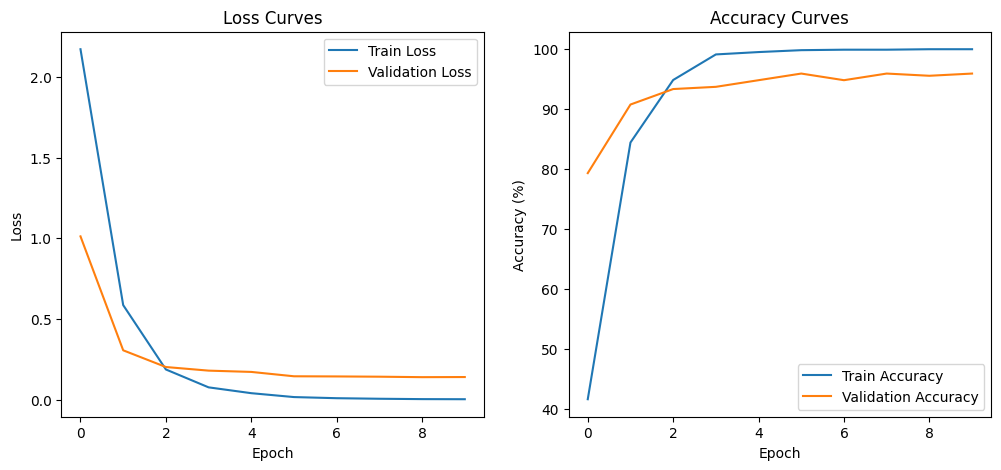

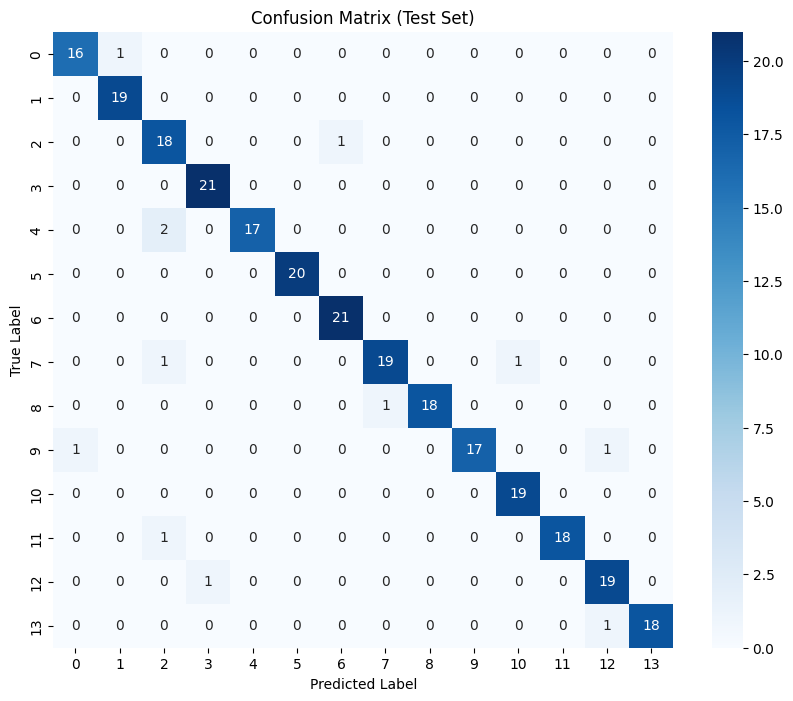

In [71]:
# Visualize learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()


# confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


